In [1]:
# Bibliotecas
import sys, pandas as pd, numpy as np
import plotly.express as px
import seaborn as sns, numpy as np, os
from os.path import exists
sys.path.append('../')

from env.RiverProblem import RiverProblem
from rl_utils.VizTools import VizTools

# Modelos
from models.ValueIteration import ValueIteration
from models.PolicyIteration import PolicyIteration
from models.RS_PolicyIteration import RS_PolicyIteration
from models.PieceLinear_RSPI import PieceLinear_RSPI

from evaluation.AverageCosts import AverageCosts

%load_ext autoreload
%autoreload 2

# Experimentos - 1S2023

|Data|Descritivo|
|--|--|
|03-2023|Primeiros experimentos com confecção de artigo|

---

## Referências

**Exponential**

2013 MICAI: Shortest Stochastic Path with Risk Sensitive Evaluation \
ou 2016 BRACIS: Extreme Risk Averse Policy for Goal-Directed Risk-Sensitive MDP

**Piecewise Linear**

2020 MICAI: Risk-Sensitive Piecewise-Linear Policy Iteration for SSP-MDP

In [81]:
# ----------------------------------------------
# -- Configurações Iniciais --------------------
# ----------------------------------------------

run_value_iteration = False
run_policy_iteration = False
run_EUF_RSPI = True
run_PWL_RSPI = True

# -- Configurações Rio

grid_size = (5, 20)
goal_state = (4, 0)

rp = RiverProblem(grid_size, goal_state, dead_end=False)
block_type = rp.build_block_type()

In [34]:
def run_river_problem(river_flow, model_obj, epsilon=None, vl_lambda=None, discount_factor=None, 
                                     k=None, gamma=None, alpha=None, _log=False):
    transition_probabilities = rp.build_transition_probabilities(block_type, river_flow=river_flow)

    is_ok, dict_verification = rp._verify_sum_probabilities(transition_probabilities, block_type)
    if not is_ok: print(f'Soma das Probabilidades está válida? {is_ok}')
    
    if epsilon != None and discount_factor != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, 
                         num_actions=4, discount_factor=discount_factor, epsilon=epsilon)
    elif epsilon != None and vl_lambda != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, vl_lambda,
                         num_actions=4, epsilon=epsilon)
    elif epsilon != None and k != None and gamma != None and alpha != None:
        rnp = model_obj(grid_size, goal_state, transition_probabilities, costs, k, alpha, gamma,
                         num_actions=4, epsilon=epsilon)
    
    num_iterations, time = rnp.run_converge()
    if _log: print(f'Número de Iterações: {num_iterations}')
    if _log: print(f'Tempo de Execução: {time}s')
    
    return rnp

# Value Iteration

In [22]:
# Value Iteration - Configs
if run_value_iteration:
    discount_factor = 0.95
    epsilon = 0.001

    costs = {0: 1, 1: 1, 2: 1, 3: 1}
    block_type = rp.build_block_type()

In [23]:
# Value Iteration - Run
if run_value_iteration:
    value_iteration_01 = \
    run_river_problem(river_flow=0.1, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
    value_iteration_05 = \
    run_river_problem(river_flow=0.75, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)
    value_iteration_09 = \
    run_river_problem(river_flow=0.9, model_obj=ValueIteration, epsilon=epsilon, discount_factor=discount_factor)

In [24]:
# Value Iteration - Displays
if run_value_iteration:
    display(value_iteration_01)
    display(value_iteration_05)
    display(value_iteration_09)

# Policy Iteration

Definimos o algoritmo de Policy Iteration da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{(\pi_i)}(s)=r(s,\pi_i(s))+\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[r(s,a)+\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$

In [25]:
# Policy Iteration - Configs
if run_policy_iteration:
    discount_factor = 0.99
    epsilon = 0.001
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [26]:
# Policy Iteration - Run
if run_policy_iteration:
    policy_iteration_01 = \
    run_river_problem(river_flow=0.1, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
    policy_iteration_05 = \
    run_river_problem(river_flow=0.5, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)
    policy_iteration_09 = \
    run_river_problem(river_flow=0.9, model_obj=PolicyIteration, epsilon=epsilon, discount_factor=discount_factor)

In [27]:
# Policy Iteration - Displays
if run_policy_iteration:
    display(policy_iteration_01)
    display(policy_iteration_05)
    display(policy_iteration_09)

# Exponential Utility Function for RS-MDP

Definimos o algoritmo de Risk Sensitive MDP da seguinte forma:

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$V^{\pi_i}(s_G)=-\text{sign}(\lambda)$$
    $$V^{(\pi_i)}(s)=\text{exp}(-\lambda r(s,\pi_i(s)))\sum_{s'\in S} T(s, \pi_i(s), s') V^{\pi_i}(s') \forall s \neq s_G \in S$$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$\pi_{i+1}(s)=\text{argmax}_{a \in A_s}[\text{exp}(-\lambda r(s,a))\sum_{s'\in S} T(s, a, s') V^{\pi_i}(s')]$$
    
    
When λ < 0 (risk prone) and the policy π is proper, then π is also λ-feasible. However, this is not guaranteed for all policies when λ > 0 (risk averse). Given a GD-RSMDP, no result exists on how to determine the set of λ > 0 such that exists a λ-feasible policy.


In [76]:
# Exponential Utility Function for RSPI - Configs
if run_EUF_RSPI:
    EUF_RSPI = {}

    range_river_flow = [0.75]
    range_lambda     = [0.5, 0.25, 0.1, 0.05, 0, -0.05, -0.1, -0.25] 
    epsilon = 0.001
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [77]:
# Exponential Utility Function for RS-MDP - Run
if run_EUF_RSPI:
    for river_flow in range_river_flow:
        for vl_lambda in range_lambda:
            EUF_RSPI[(river_flow, vl_lambda)] = \
                run_river_problem(river_flow=river_flow, model_obj=RS_PolicyIteration, 
                vl_lambda=vl_lambda, epsilon=epsilon)

..\models\RS_PolicyIteration.py:127: RuntimeWarning: overflow encountered in double_scalars
  
..\models\RS_PolicyIteration.py:128: RuntimeWarning: invalid value encountered in multiply
  self.V = V.copy()


In [78]:
# Exponential Utility Function for RS-MDP - Keys
if run_EUF_RSPI:
    display(EUF_RSPI.keys())

dict_keys([(0.75, 0.5), (0.75, 0.25), (0.75, 0.1), (0.75, 0.05), (0.75, 0), (0.75, -0.05), (0.75, -0.1), (0.75, -0.25)])

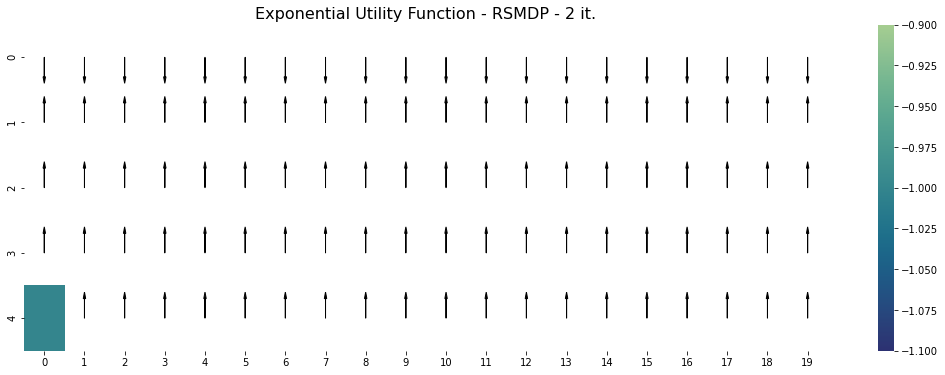

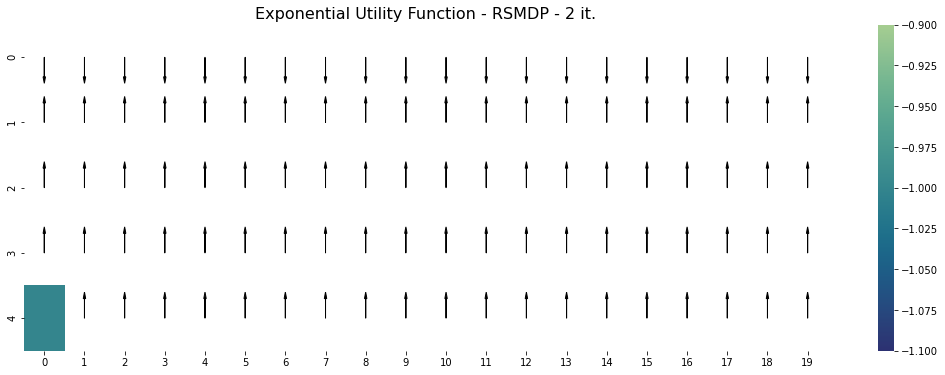

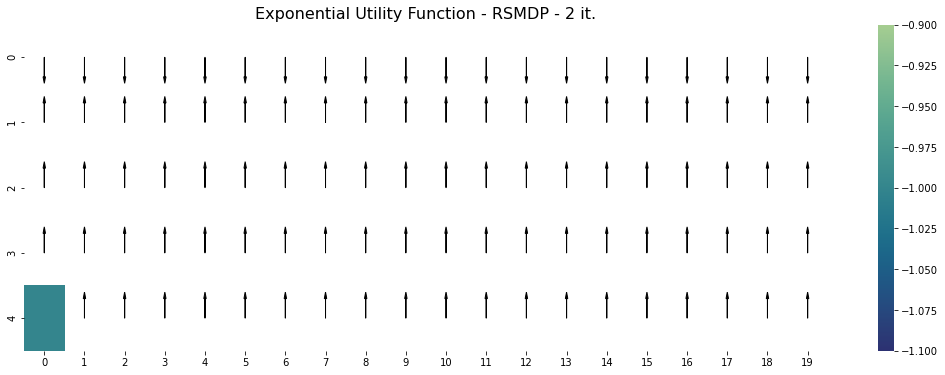

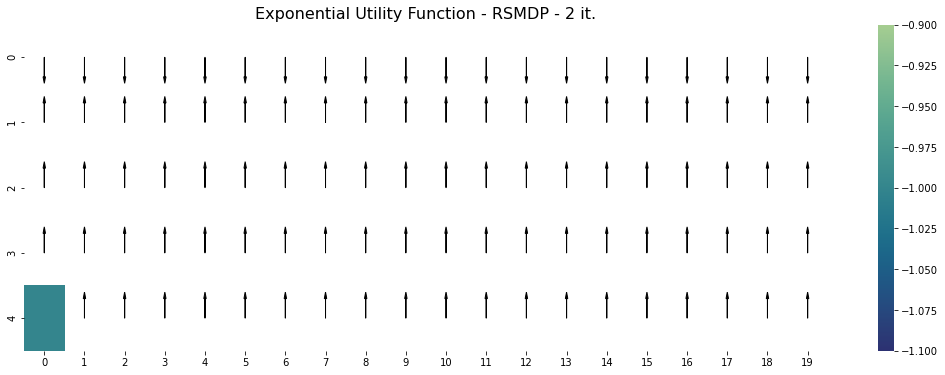

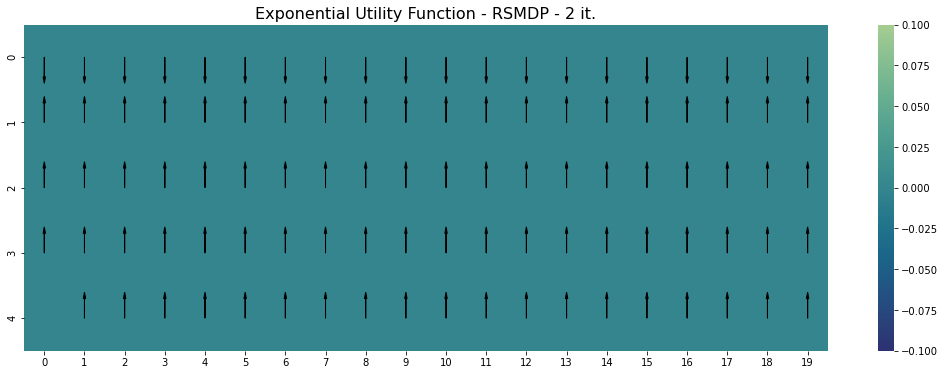

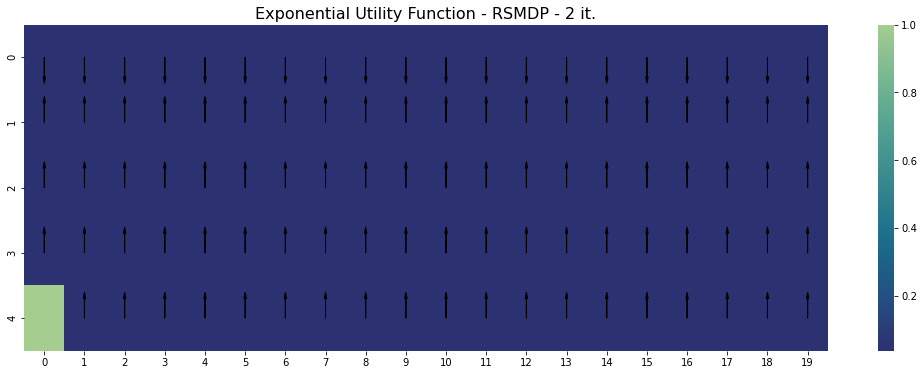

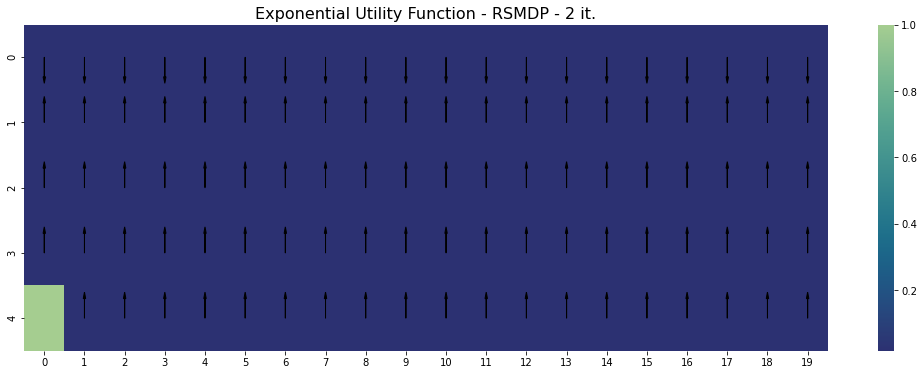

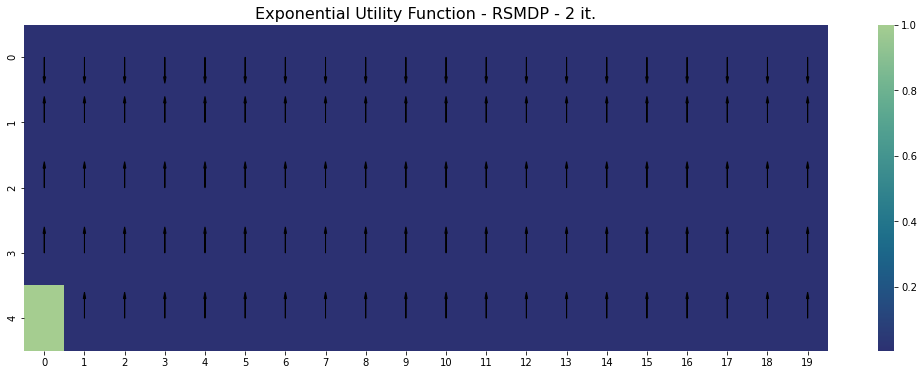

{(0.75,
  0.5): RiverProblem - 
 Lambda: 0.5 
 Epsilon: 0.001 ,
 (0.75,
  0.25): RiverProblem - 
 Lambda: 0.25 
 Epsilon: 0.001 ,
 (0.75,
  0.1): RiverProblem - 
 Lambda: 0.1 
 Epsilon: 0.001 ,
 (0.75,
  0.05): RiverProblem - 
 Lambda: 0.05 
 Epsilon: 0.001 ,
 (0.75,
  0): RiverProblem - 
 Lambda: 0 
 Epsilon: 0.001 ,
 (0.75,
  -0.05): RiverProblem - 
 Lambda: -0.05 
 Epsilon: 0.001 ,
 (0.75,
  -0.1): RiverProblem - 
 Lambda: -0.1 
 Epsilon: 0.001 ,
 (0.75,
  -0.25): RiverProblem - 
 Lambda: -0.25 
 Epsilon: 0.001 }

In [79]:
# Exponential Utility Function for RS-MDP - Display
if run_EUF_RSPI: 
    display(EUF_RSPI)
#     display(EUF_RSMDP[(0.2, 0)])

# PieceLinear - RSPI (Risk Sensitive Policy Iteration)

Define-se uma transformação por partes linear $X^{(k)}$ que depende de um parâmetro $x$ (diferença temporal) seja positiva ou não e um fator de risco $k$:

$$X^{(k)}(x)= \left\{ \begin{array} & (1-k)x & \text{, if x < 0,} \\ (1+k)x & \text{, otherwise.} \end{array} \right. $$

1. Escolhe uma política $\pi_0$ arbitrária;
2. Define $i=0$ como a quantidade de iterações;
3. Para cada iteração, enquanto ($i=0$ ou $\pi_i \neq \pi_{i-1}$) faça: \
    3.1. Policy Evaluation: obtém o valor da política atual $\pi_i$ para cada $s \in S$ resolvendo o seguinte sistema de equações: \
    $$
    O^{\pi}_{\alpha k}[V](s) = V(s) + \alpha \sum_{s'\in S} P(s'|s, \pi(s)) X^{(k)}(C(s,\pi(s),s')+\gamma V(s') - V(s))    
    $$
    3.2. Policy Improvement: melhora a política atual realizando uma atualização para todo $s \in S$: \
    $$
    \pi'(s)=\text{argmin}_{a\in A}\sum_{s'\in S} P(s'|s, a) X^{(k)}(C(s,a,s')+\gamma V(s') - V^\pi_k(s))
    $$

In [107]:
# Piecewise-Linear RSPI - Configs
if run_PWL_RSPI:
    PWL_RSPI = {}
    
    range_river_flow = [0.2] # [rf/10 for rf in range(1, 10)]
    range_k     = [0] # [v/10 for v in range(-9, 10)]
    gamma       = 1
    range_alpha = [1/(1+abs(k))] # [1/(1+abs(k)) for k in range_k]
    epsilon = 0.001
    
    costs = {0: 1, 1: 1, 2: 1, 3: 1}

In [110]:
# Piecewise-Linear RSPI - Run
for river_flow in range_river_flow:
    for i in range(0, len(range_k)):
        print(range_alpha[i])
        PWL_RSPI[(river_flow, range_k[i], gamma, range_alpha[i])] = \
            run_river_problem(river_flow=river_flow, model_obj=PieceLinear_RSPI,
            gamma=gamma, k=range_k[i], alpha=range_alpha[i], epsilon=epsilon)

0.5263157894736842
0teração: 0
0.5263157894736842
1.3296398891966759
2.278757836419303
3.3046093875891067
4.37084704609953
5.4583405505787
6.557021342409842
7.661590180215706
8.769257989587214
9.878556836624849
10.988714124539394
12.099323223441786
13.21017011760094
14.32114216715839
15.4321800879781
16.54325267788321
17.65434351467537
18.765443955092298
19.876549450048575
20.98765760528872
22.09876716067827
23.20987745298856
24.32098813315187
25.43209901744835
26.54321000918334
27.654321057464912
28.765432135507844
29.87654322921465
30.9876543311656
32.098765437455576
33.20987654602925
34.32098765580487
35.432098766213095
36.543209876954265
37.65432098787067
38.7654320988793
39.87654320993648
40.98765432101921
42.09876543211538
43.20987654321863
44.3209876543256
45.43209876543453
46.543209876544495
47.654320987655005
48.7654320987658
49.87654320987674
50.987654320987765
52.09876543209883
53.209876543209916
54.320987654321016
55.43209876543212
56.54320987654323
57.65432098765434
58.765

KeyboardInterrupt: 

In [ ]:
RSPI.keys()

In [ ]:
#RSPI[(0.5, -0.9, 1, 0.95)]
RSPI[(0.2, 0.9999999, 1, 0.95)]

# Comparando Políticas Geradas

* Fixar em um ambiente (0.2 por exemplo) que o neutro atravessa no meio do rio para observar mais facil os comportamentos;
* E para um só tamanho para validar o processo;
* Residual

Policy Evaluation Exponencial

1 - 
PEXP(env, lambda, pi) -> R, avaliação da política para este mundo com lambda/pi;

Gráfico: PEXP(env, lambda, pi_lambda) por lambda
         PEXP(env, lambda, pi_linear) por lambda

pi_linear = argmax_{pi_k} PEXP(env, lambda, pi_k)

2 - Contrário da (1)
P(env, K, pi) -> R, avaliação da política para este mundo com K/pi;

3 -
Lambda, K

k_max = argmax_{k} PEXP(env, lambda, pi_k)

4 - Contrário da (3)

lambda_max = argmax_{lambda} PLINEAR(env, k, pi_lambda)

---

_* Calcular a variancia de uma política através de programação dinâmica sem usar simulações_

### RS-MDP with Exponential Utility Function

In [ ]:
def build_res_dataframe_RSMDP(d, c, path, model):
    res = pd.DataFrame(d.items(), columns=c)
    res.insert(0, 'Model', model)
    res.insert(2, 'RiverFlow', [v[0] for v in res['Keys']])
    res.insert(3, 'Lambda', [v[1] for v in res['Keys']])
    res.insert(4, 'DiscountFactor', [v[2] for v in res['Keys']])
    
    res.to_excel(path)
    
    return res

In [ ]:
# --------------------------------------------------------------------
# Gerando simulações para RS-MDP with Exponential Utility Function ---
# --------------------------------------------------------------------

nm_model = 'EXP-UTILITY_RSMDP-v4'
total_simulations = 10000
average_costs, std_costs, dict_costs = {}, {}, {}

nm_RSMDP_path_std = os.path.join('saidas', f'SAIDA_STD_{nm_model}.xlsx')
nm_RSMDP_path_avg = os.path.join('saidas', f'SAIDA_MEAN_{nm_model}.xlsx')

if exists(nm_RSMDP_path_std) and exists(nm_RSMDP_path_avg):
    RSMDP_std_costs = pd.read_excel(nm_RSMDP_path_std)
    RSMDP_average_costs = pd.read_excel(nm_RSMDP_path_avg)
else:
    for key in RSMDP.keys():
        print(f'Processando [{key}]', end='\r')
        ac = AverageCosts(RSMDP[key], costs, give_up=1000)
        res_costs, res_it = ac.run_simulations(total_simulations)
        lst_costs = [c[1] for c in res_costs.items()]

        dict_costs[key] = lst_costs
        average_costs[key] = np.mean(lst_costs)
        std_costs[key] = np.std(lst_costs)

    RSMDP_std_costs = build_res_dataframe_RSMDP(std_costs, ['Keys', 'Std'], 
                                          path=nm_RSMDP_path_std, model=nm_model)\
                                          .sort_values(by=['RiverFlow', 'Lambda'])
    RSMDP_average_costs = build_res_dataframe_RSMDP(average_costs, ['Keys', 'Mean'], 
                                          path=nm_RSMDP_path_avg, model=nm_model)\
                                          .sort_values(by=['RiverFlow', 'Lambda'])

In [ ]:
RSMDP_std_costs['Lambda_STR'] = [str(l) for l in RSMDP_std_costs['Lambda']]
RSMDP_average_costs['Lambda_STR'] = [str(l) for l in RSMDP_average_costs['Lambda']]

In [ ]:
RSMDP_std_costs = RSMDP_std_costs.sort_values(by=['Lambda_STR', 'RiverFlow'], ascending=False)
RSMDP_average_costs = RSMDP_average_costs.sort_values(by=['Lambda_STR', 'RiverFlow'], ascending=False)

### PieceLinear - RSPI (Risk Sensitive Policy Iteration)

In [ ]:
def build_res_dataframe_RSPI(d, c, path, model):
    res = pd.DataFrame(d.items(), columns=c)
    res.insert(0, 'Model', model)
    res.insert(2, 'RiverFlow', [v[0] for v in res['Keys']])
    res.insert(3, 'K', [v[1] for v in res['Keys']])
    res.insert(4, 'Alpha', [v[2] for v in res['Keys']])
    res.insert(5, 'Gamma', [v[3] for v in res['Keys']])
    
    res.to_excel(path)
    
    return res

In [ ]:
# --------------------------------------------------------------------------------
# Gerando simulações para PieceLinear - RSPI (Risk Sensitive Policy Iteration) ---
# --------------------------------------------------------------------------------

nm_model = 'LINEAR_RSPI'
total_simulations = 10000
average_costs, std_costs, dict_costs = {}, {}, {}

nm_LRSPI_path_std = os.path.join('saidas', f'SAIDA_STD_{nm_model}.xlsx')
nm_LRSPI_path_avg = os.path.join('saidas', f'SAIDA_MEAN_{nm_model}.xlsx')

if exists(nm_LRSPI_path_std) and exists(nm_LRSPI_path_avg):
    RSPI_std_costs = pd.read_excel(nm_LRSPI_path_std)
    RSPI_average_costs = pd.read_excel(nm_LRSPI_path_avg)
else:
    for key in RSPI.keys():
        print(f'Processando [{key}]', end='\r')
        ac = AverageCosts(RSPI[key], costs, give_up=1000)
        res_costs, res_it = ac.run_simulations(total_simulations)
        lst_costs = [c[1] for c in res_costs.items()]

        dict_costs[key] = lst_costs
        average_costs[key] = np.mean(lst_costs)
        std_costs[key] = np.std(lst_costs)
    
    RSPI_std_costs = build_res_dataframe_RSPI(std_costs, ['Keys', 'Std'], 
                                         path=nm_LRSPI_path_std, model=nm_model)
    RSPI_average_costs = build_res_dataframe_RSPI(average_costs, ['Keys', 'Mean'], 
                                             path=nm_LRSPI_path_avg, model=nm_model)

In [ ]:
RSPI_std_costs = RSPI_std_costs.sort_values(by=['K', 'RiverFlow'], ascending=False)
RSPI_std_costs = RSPI_std_costs[RSPI_std_costs['K'] != -1]

RSPI_average_costs = RSPI_average_costs.sort_values(by=['K', 'RiverFlow'], ascending=False)
RSPI_average_costs = RSPI_average_costs[RSPI_average_costs['K'] != -1]

# Análises

In [ ]:
fig = px.line(RSMDP_std_costs, x='Lambda_STR', y='Std', color='RiverFlow', title='Standard Deviation for each' + \
                                                                     'value of Lambda in different River Flows')
fig.show()

fig = px.line(RSPI_std_costs, x='K', y='Std', color='RiverFlow', title='Standard Deviation for each' + \
                                                                     'value of K in different River Flows')
fig.show()

In [ ]:
fig = px.line(RSMDP_average_costs, x='Lambda_STR', y='Mean', color='RiverFlow', title='Mean for each' + \
                                                                     'value of Lambda in different River Flows')
fig.show()

fig = px.line(RSPI_average_costs, x='K', y='Mean', color='RiverFlow', title='Mean for each' + \
                                                                     'value of K in different River Flows')
fig.show()

# Outras Análises

In [ ]:
fig = px.scatter(RSPI_std_costs, x='RiverFlow', y='Std', color='K')
fig.show()

In [ ]:
print(list(dict_costs.keys())[-6])
p = sns.histplot(dict_costs[(0.9, 0.5, 1, 0.95)])